# Visualize Active Learning

In this example, we demonstrate the GP fitting process on a 1D function and visualize the active learning function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import alabi
from alabi.core import SurrogateModel
import alabi.utility as ut

In [2]:
def test1d_fn(theta):
    theta = np.asarray(theta)
    return -np.sin(3*theta) - theta**2 + 0.7*theta

# domain of the function
bounds = [(-2,3)]

In [4]:
np.random.seed(7)

sm = SurrogateModel(lnlike_fn=test1d_fn, 
                    bounds=bounds, 
                    savedir=f"results/test1d")

sm.init_samples(ntrain=6, sampler="sobol")
sm.init_gp(kernel="ExpSquaredKernel", 
           fit_amp=True, 
           fit_mean=True, 
           white_noise=-12, 
           gp_scale_rng=[-1,1],
           theta_scaler=alabi.no_scaler,
           y_scaler=alabi.no_scaler)

def bape(xgrid):
    return -np.array([ut.bape_utility(np.array([x]), sm._y, sm.gp, sm.bounds) for x in xgrid])

def agp(xgrid):
    return -np.array([ut.agp_utility(np.array([x]), sm._y, sm.gp, sm.bounds) for x in xgrid])

AttributeError: 'list' object has no attribute 'reshape'

Define a plot function for inspecting the current GP fit so that we can compare the fit before and after active learning training.

In [4]:
def plot_current_gp(sm):
    xgrid = np.arange(sm.bounds[0][0], sm.bounds[0][1]+.1, .01)
    mu, var = sm.gp.predict(sm._y, xgrid, return_cov=False, return_var=True)
    eval_bape = bape(xgrid)
    eval_agp = agp(xgrid)
    opt_bape = xgrid[np.argmax(eval_bape)]
    opt_agp = xgrid[np.argmax(eval_agp)]
    title = f"Ninitial = {sm.ninit_train}, active learning iterations = {len(sm._theta) - sm.ninit_train}"

    fig, axs = plt.subplots(2, 1, figsize=[8,12], sharex=True)
    plt.subplots_adjust(hspace=0)
    axs[0].plot(xgrid, test1d_fn(xgrid), color="k", linestyle="--", label="true function")
    axs[0].scatter(sm._theta, sm._y, color="r", label="GP fit")
    axs[0].plot(xgrid, mu, color="r")
    axs[0].fill_between(xgrid, mu - np.sqrt(var), mu + np.sqrt(var), color="r", alpha=0.2)

    axs[1].plot(xgrid, eval_agp, color="g", label="AGP")
    axs[0].axvline(opt_agp, color="g", linestyle="dotted")
    axs[1].axvline(opt_agp, color="g", linestyle="dotted")
    axs[1].plot(xgrid, eval_bape, color="b", label="BAPE")
    axs[0].axvline(opt_bape, color="b", linestyle="dotted")
    axs[1].axvline(opt_bape, color="b", linestyle="dotted")

    axs[0].set_xlim(sm.bounds[0][0], sm.bounds[0][1])
    axs[0].set_ylabel("GP surrogate model", fontsize=25)
    axs[1].set_ylabel("Active Learning function", fontsize=25)
    axs[1].set_xlabel("x", fontsize=25)
    axs[0].legend(loc="lower left", fontsize=18)
    axs[1].legend(loc="lower left", fontsize=18)
    axs[0].set_title(title, fontsize=25)
    axs[0].minorticks_on()
    axs[1].minorticks_on()
    plt.close()
    return fig

Visualize what the GP fit looks like after training with only 6 initial points. Vertical lines show the optimum value of the acquisition function where `alabi` will choose the next training point.

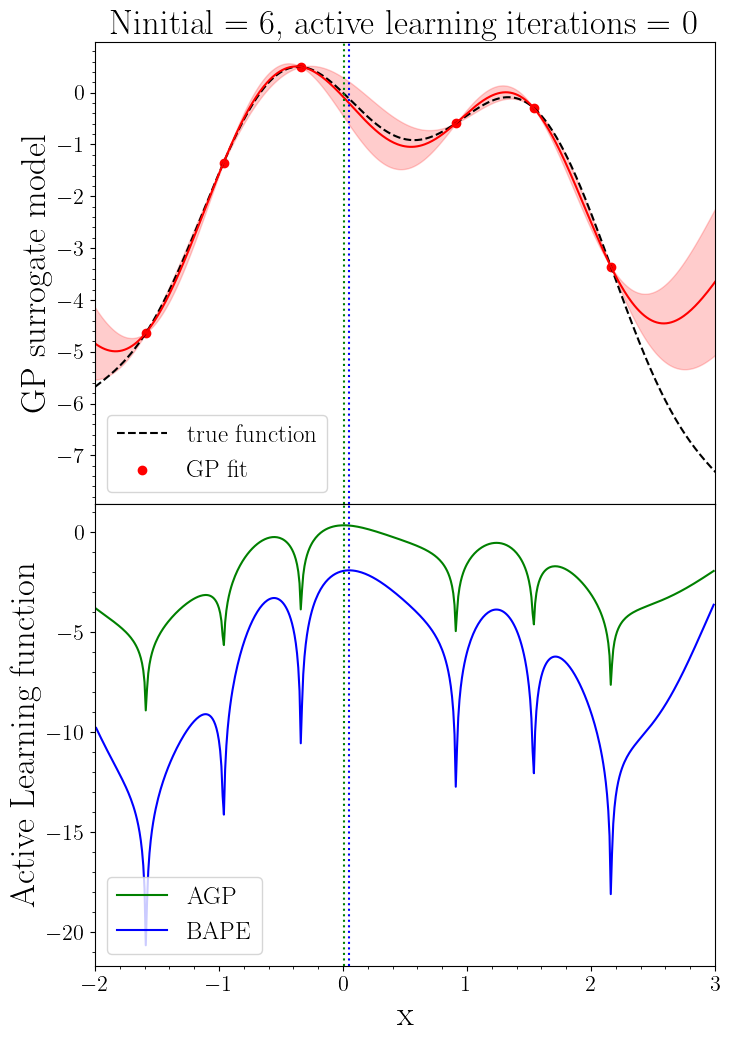

In [5]:
plot_current_gp(sm)

In [ ]:
sm.active_train(niter=20, algorithm="bape", gp_opt_freq=10, obj_opt_method="nelder-mead")

Running 20 active learning iterations using bape...


 50%|█████     | 10/20 [00:00<00:00, 11.56it/s]

Optimized 4 hyperparameters: (0.012s)


100%|██████████| 20/20 [00:01<00:00, 11.69it/s]

Optimized 4 hyperparameters: (0.013s)
Caching model to results/test1d/surrogate_model...


After 20 iterations the convergence is much better, particularly in the high likelihood regions which are most important for sampling.

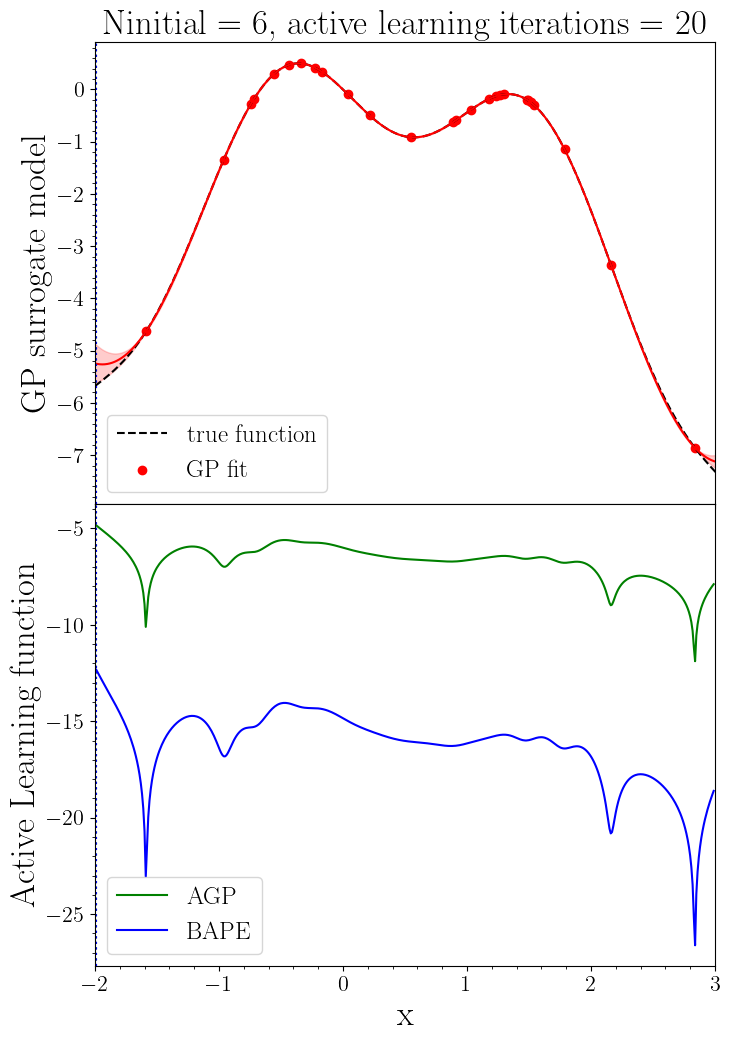

In [7]:
plot_current_gp(sm)

In [8]:
sm.run_emcee(like_fn=sm.surrogate_log_likelihood, nwalkers=20, nsteps=int(5e4))

No prior_fn specified. Defaulting to uniform prior with bounds [[-2  3]]


Running emcee with 20 walkers for 50000 steps on 128 cores...


100%|██████████| 50000/50000 [06:06<00:00, 136.39it/s]


burn-in estimate: 92
thin estimate: 23

Total samples: 43380
Mean acceptance fraction: 0.721
Mean autocorrelation time: 46.096 steps
Caching model to results/test1d/surrogate_model...


In [9]:
sm.run_dynesty(like_fn=sm.surrogate_log_likelihood)

Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 50 live points on 1 cores...


10281it [00:27, 373.98it/s, batch: 76 | bound: 0 | nc: 1 | ncall: 35840 | eff(%): 28.652 | loglstar: -1.299 <  0.500 <  0.279 | logz: -0.813 +/-  0.029 | stop:  0.988]     


Caching model to results/test1d/surrogate_model...


Compare the posterior sampled using `emcee` vs `dynesty`:

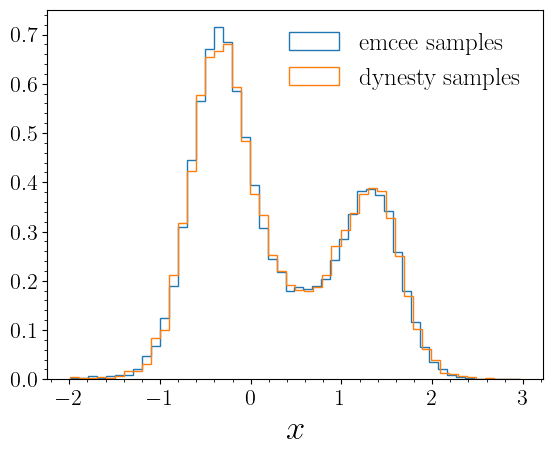

In [10]:
plt.hist(sm.emcee_samples.T[0], bins=50, histtype='step', density=True, label="emcee samples")
plt.hist(sm.dynesty_samples.T[0], bins=50, histtype='step', density=True, label="dynesty samples")
plt.xlabel("$x$", fontsize=25)
plt.legend(loc="upper right", fontsize=18, frameon=False)
plt.minorticks_on()
plt.show()